# Answering Business Questions using SQL

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q='SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
    return(run_query(q))

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


SELECT
  g.name genre_name,
  sum(t.track_id) sum_of_tracks,
  100*sum(t.track_id)/(
    SELECT
        sum(t.track_id) sum_of_tracks
            FROM invoice_line il
            INNER JOIN track t ON t.track_id = il.track_id
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE country = "USA"
    ) Share
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN customer c ON c.customer_id = i.customer_id
WHERE country = "USA"
GROUP BY 1

In [6]:
q="""\
SELECT
      g.name genre_name,
      sum(t.track_id) sum_of_tracks,
  100*sum(t.track_id)/(
    SELECT
        sum(t.track_id) sum_of_tracks
            FROM invoice_line il
            INNER JOIN track t ON t.track_id = il.track_id
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE country = "USA"
    ) Share
FROM invoice_line il
INNER JOIN track t ON t.track_id = il.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN customer c ON c.customer_id = i.customer_id
WHERE country = "USA"
GROUP BY 1
"""
genre_sales_usa = run_query(q)

In [7]:
genre_sales_usa['sum_of_tracks']=genre_sales_usa['sum_of_tracks'].astype('float')
genre_sales_usa['Share']=genre_sales_usa['Share'].astype('float')

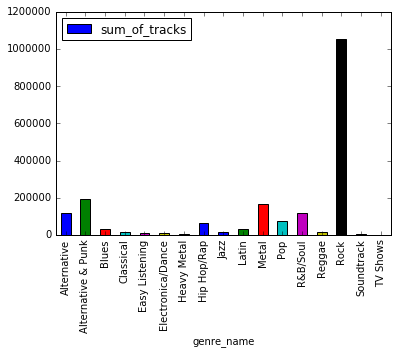

In [8]:
genre_sales_usa.plot.bar(x='genre_name', y='sum_of_tracks')

Rock and roll

In [9]:
q="""\
         SELECT
            e.first_name || " " || e.last_name employee_name,
            e.hire_date hired,
            COUNT(c.customer_id) customer_amount,
            SUM(i.total) total
            FROM invoice i
                left JOIN customer c ON c.customer_id = i.customer_id
                left JOIN employee e ON e.employee_id = c.support_rep_id
            GROUP BY e.employee_id 

"""
sales = run_query(q)


In [10]:
print(sales)

   employee_name                hired  customer_amount    total
0   Jane Peacock  2017-04-01 00:00:00              212  1731.51
1  Margaret Park  2017-05-03 00:00:00              214  1584.00
2  Steve Johnson  2017-10-17 00:00:00              188  1393.92


Date when hired

In [11]:
q="""\
  SELECT
            c.country country,
            COUNT(DISTINCT(c.customer_id)) number_of_customers,
            COUNT(i.invoice_id) orders,
            SUM(i.total) total_value_of_sales,
            (SUM(i.total)/COUNT(DISTINCT(c.customer_id))) average_value_of_sales_per_customer,
            AVG(i.total) average_order_value
            FROM invoice i
                INNER JOIN customer c ON c.customer_id = i.customer_id
            GROUP BY country
"""
list = run_query(q)


Easier to do the "Others" with Pandas

In [12]:
number_of_customers = list[list['number_of_customers'] == 1].sum()[1]
orders =  list[list['number_of_customers'] == 1].sum()[2]
total_value_of_sales =  list[list['number_of_customers'] == 1].sum()[3]
average_value_of_sales_per_customer = total_value_of_sales / number_of_customers
average_order_value = total_value_of_sales / orders
new_row = {'country':'Other', 'number_of_customers':number_of_customers, 'orders':orders, 'total_value_of_sales':total_value_of_sales,'average_value_of_sales_per_customer':average_value_of_sales_per_customer, 'average_order_value': average_order_value}
list = list.append(new_row, ignore_index=True)
list = list.drop(list[list['number_of_customers'] == 1].index)
print(list)

           country  number_of_customers  orders  total_value_of_sales  \
4           Brazil                    5      61                427.68   
5           Canada                    8      76                535.59   
7   Czech Republic                    2      30                273.24   
10          France                    5      50                389.07   
11         Germany                    4      41                334.62   
13           India                    2      21                183.15   
19        Portugal                    2      29                185.13   
22             USA                   13     131               1040.49   
23  United Kingdom                    3      28                245.52   
24           Other                   15     147               1094.94   

    average_value_of_sales_per_customer  average_order_value  
4                             85.536000             7.011148  
5                             66.948750             7.047237  
7      

In [13]:
q="""\
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    ),
    
    album AS
    (
    SELECT t.album_id album_id
    FROM track t 
    WHERE t.track_id = ifs.first_track_id
    ),
    
    album_tracks AS
    (
    SELECT t.track_id track_id
    FROM track t    
    WHERE t.album_id = (SELECT album_id FROM album)
    ),

    invoice_tracks AS
    (
    SELECT il.track_id track_id
    FROM invoice_line il
    WHERE il.invoice_id = ifs.invoice_id
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(invoice_id) FROM invoice) percent

FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                (
                SELECT track_id 
                FROM album_tracks
    
                EXCEPT
    
                SELECT track_id 
                FROM invoice_tracks
                )
                IS NULL
                
                AND
                
                (
                SELECT track_id 
                FROM invoice_tracks

                EXCEPT 

                SELECT track_id 
                FROM album_tracks
                )
                IS NULL
    
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;


"""
sales = run_query(q)


In [14]:
sales

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
